<a href="https://colab.research.google.com/github/emrecobann/basic-pytorch-projects/blob/main/neural_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
import numpy  as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL.Image as Image
import torchvision.transforms as transforms
import torchvision.models as models
import cv2

In [249]:
from torchvision.transforms.functional import normalize
transformer = transforms.Compose([
                                  transforms.Resize((380,380)),
      
                                  transforms.ToTensor()
])

In [250]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [251]:
def image_loader(file):
  img = Image.open(file)
  img = transformer(img)
  img = img.unsqueeze(0)
  return img.to(device,torch.float)

In [252]:
style_img = image_loader("/content/yildizli_gece_tablosunun_hikayesi_h45855_6f7b6.jpg")
content_img = image_loader("/content/National-Horse-Day-1-300x300.jpg")
gen_image=content_img.clone().requires_grad_(True)

In [253]:

def imshow(tensor):
  img = tensor.cpu().clone()
  img = img.squeeze(0)
  img = transforms.ToPILImage()(img)
  print(type(img))
  plt.imshow(img,)
  plt.pause(0.001)

<class 'PIL.Image.Image'>


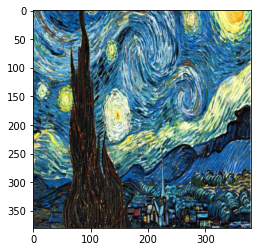

In [254]:
imshow(style_img)

<class 'PIL.Image.Image'>


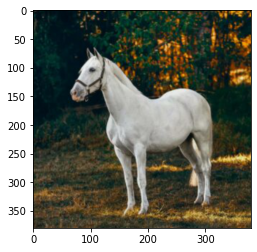

In [255]:
imshow(content_img)

In [256]:
def content_loss(gen,org):
  return torch.mean((gen-org)**2)

In [257]:
def style_loss(gen,style):
 
    batch_size,channel,height,width=gen.shape

    ##gram matrices 
    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    # mse loss between gram matrices
    style_l=torch.mean((G-A)**2)
    return style_l

In [258]:
def total_loss(generated,style,content,alpha=50,beta=10):
  S_loss=0
  C_loss=0
  for gen,stl,cont in zip(generated,style,content): ##looping through returned list of features from model
    C_loss += content_loss(gen,cont)
    S_loss+=style_loss(gen,stl)
    
  total = alpha*C_loss + beta*S_loss
  return total

In [259]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28'] ##these are indexes of conv layers we need those
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=torchvision.models.vgg19(pretrained=True).features[:29]
    

    def forward(self,x):
       
        features=[]
   
        for layer_num,layer in enumerate(self.model):
            x=layer(x)
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features

In [260]:
model = VGG().to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [264]:
epochs = 1500
lr = 0.0025
optimizer = optim.Adam(params=[gen_image],lr=lr)

<class 'PIL.Image.Image'>


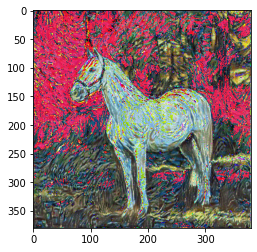

In [265]:
for epoch in range(epochs):
  generated_f = model(gen_image)
  style_f = model(style_img)
  content_f = model(content_img)
  loss = total_loss(generated_f,style_f,content_f)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

imshow(gen_image)